In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             roc_curve, precision_recall_curve, f1_score, precision_score, 
                             recall_score, auc)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/bank-additional-full.csv', sep=';')
df = df.drop_duplicates()

In [3]:
# Feature Engineering - Handle Multicollinearity
# Drop highly correlated economic indicators (keep only euribor3m)
df = df.drop(['emp.var.rate', 'nr.employed'], axis=1)
df = df.drop(['duration'], axis=1)


In [4]:
# Separate Features and Target
X = df.drop('y', axis=1)
y = df['y'].map({'no': 0, 'yes': 1})

In [5]:
# Encode Categorical Variables
categorical_cols = X.select_dtypes(include='object').columns.tolist()
print(f"\nCategorical columns to encode: {categorical_cols}")

# Store encoders for interpretation
le_dict = {}
X_encoded = X.copy()

for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col])
    le_dict[col] = le
    print(f"{col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")


Categorical columns to encode: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
job: {'admin.': np.int64(0), 'blue-collar': np.int64(1), 'entrepreneur': np.int64(2), 'housemaid': np.int64(3), 'management': np.int64(4), 'retired': np.int64(5), 'self-employed': np.int64(6), 'services': np.int64(7), 'student': np.int64(8), 'technician': np.int64(9), 'unemployed': np.int64(10), 'unknown': np.int64(11)}
marital: {'divorced': np.int64(0), 'married': np.int64(1), 'single': np.int64(2), 'unknown': np.int64(3)}
education: {'basic.4y': np.int64(0), 'basic.6y': np.int64(1), 'basic.9y': np.int64(2), 'high.school': np.int64(3), 'illiterate': np.int64(4), 'professional.course': np.int64(5), 'university.degree': np.int64(6), 'unknown': np.int64(7)}
default: {'no': np.int64(0), 'unknown': np.int64(1), 'yes': np.int64(2)}
housing: {'no': np.int64(0), 'unknown': np.int64(1), 'yes': np.int64(2)}
loan: {'no': np.int64(0), 'unknown': np.int64(1),

In [6]:
# Cell 6: Handle Skewed Features - Log Transform
skewed_cols = ['campaign', 'previous', 'pdays']
X_encoded_transformed = X_encoded.copy()

for col in skewed_cols:
    # Add 1 to avoid log(0)
    X_encoded_transformed[col] = np.log1p(X_encoded_transformed[col])
    print(f"Log-transformed {col}")

Log-transformed campaign
Log-transformed previous
Log-transformed pdays


In [7]:
# Cell 7: Train-Test Split with Stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded_transformed, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)
print(f"\nTrain set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Train set conversion rate: {y_train.mean()*100:.2f}%")
print(f"Test set conversion rate: {y_test.mean()*100:.2f}%")


Train set size: 32940
Test set size: 8236
Train set conversion rate: 11.27%
Test set conversion rate: 11.27%


In [8]:
# Cell 8: Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nFeatures scaled. Mean: {X_train_scaled.mean():.4f}, Std: {X_train_scaled.std():.4f}")


Features scaled. Mean: 0.0000, Std: 1.0000


In [9]:
# Cell 9: Train Logistic Regression with Class Weight
log_reg = LogisticRegression(
    class_weight='balanced',  # Handle class imbalance
    max_iter=1000,
    random_state=42,
    solver='lbfgs'
)

log_reg.fit(X_train_scaled, y_train)
print("Logistic Regression model trained successfully!")

Logistic Regression model trained successfully!


In [10]:
# Cell 10: Make Predictions
y_train_pred = log_reg.predict(X_train_scaled)
y_train_pred_proba = log_reg.predict_proba(X_train_scaled)[:, 1]

y_test_pred = log_reg.predict(X_test_scaled)
y_test_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

In [11]:
# Cell 11: Model Evaluation - Training Set
print("\n" + "="*60)
print("TRAINING SET PERFORMANCE")
print("="*60)
print(f"Accuracy: {(y_train_pred == y_train).mean():.4f}")
print(f"Precision: {precision_score(y_train, y_train_pred):.4f}")
print(f"Recall: {recall_score(y_train, y_train_pred):.4f}")
print(f"F1-Score: {f1_score(y_train, y_train_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_train, y_train_pred_proba):.4f}")


TRAINING SET PERFORMANCE
Accuracy: 0.7723
Precision: 0.2816
Recall: 0.6586
F1-Score: 0.3945
ROC-AUC: 0.7760


In [12]:
# Cell 12: Model Evaluation - Test Set
print("\n" + "="*60)
print("TEST SET PERFORMANCE")
print("="*60)
print(f"Accuracy: {(y_test_pred == y_test).mean():.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_test_pred_proba):.4f}")

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=['No Conversion', 'Conversion']))


TEST SET PERFORMANCE
Accuracy: 0.7765
Precision: 0.2903
Recall: 0.6810
F1-Score: 0.4071
ROC-AUC: 0.7854

Classification Report (Test Set):
               precision    recall  f1-score   support

No Conversion       0.95      0.79      0.86      7308
   Conversion       0.29      0.68      0.41       928

     accuracy                           0.78      8236
    macro avg       0.62      0.73      0.63      8236
 weighted avg       0.88      0.78      0.81      8236



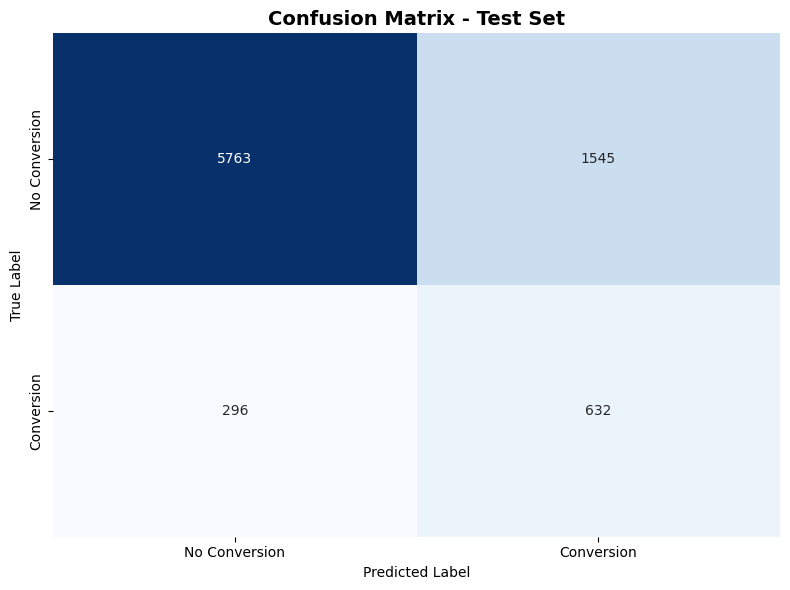

In [13]:
# Cell 13: Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Conversion', 'Conversion'],
            yticklabels=['No Conversion', 'Conversion'])
plt.title('Confusion Matrix - Test Set', fontweight='bold', fontsize=14)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

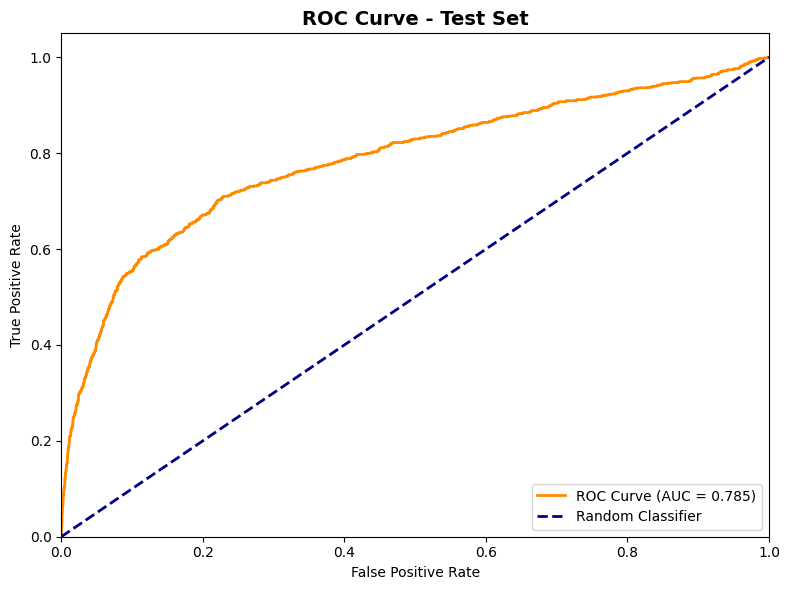

In [14]:
# Cell 14: ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set', fontweight='bold', fontsize=14)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


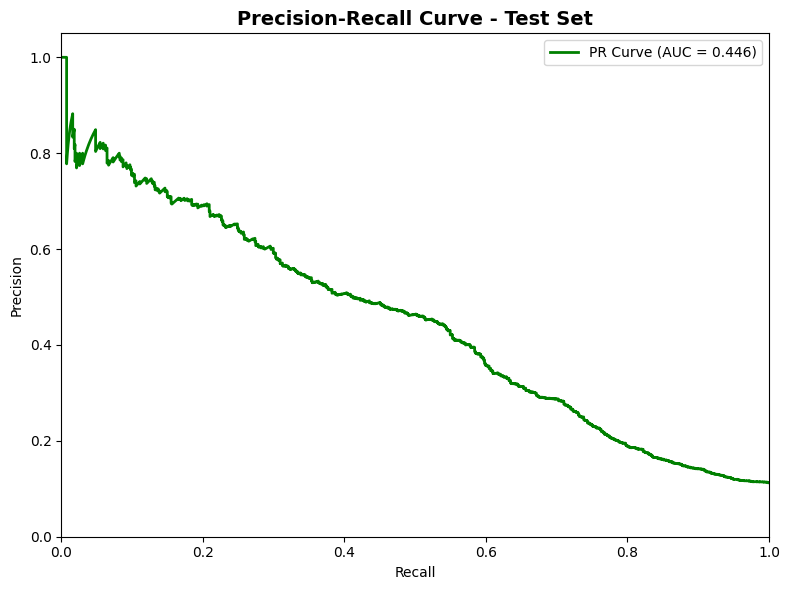

In [15]:
# Cell 15: Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_test_pred_proba)
pr_auc = auc(recall_vals, precision_vals)

plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, color='green', lw=2, label=f'PR Curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Test Set', fontweight='bold', fontsize=14)
plt.legend(loc="upper right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.show()

In [16]:
# Cell 16: Extract Feature Coefficients
feature_names = X_encoded.columns.tolist()
coefficients = log_reg.coef_[0]

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False)

print("\n" + "="*60)
print("MODEL COEFFICIENTS (Sorted by Absolute Value)")
print("="*60)
print(coef_df.to_string(index=False))

print(f"\nIntercept (Bias): {log_reg.intercept_[0]:.4f}")


MODEL COEFFICIENTS (Sorted by Absolute Value)
       Feature  Coefficient  Abs_Coefficient
     euribor3m    -0.959927         0.959927
cons.price.idx     0.382837         0.382837
       contact    -0.324242         0.324242
         pdays    -0.273311         0.273311
 cons.conf.idx     0.259379         0.259379
       default    -0.122720         0.122720
      previous    -0.102546         0.102546
      poutcome     0.101376         0.101376
         month    -0.099960         0.099960
      campaign    -0.092233         0.092233
       marital     0.084100         0.084100
           age     0.061982         0.061982
     education     0.060363         0.060363
   day_of_week     0.041407         0.041407
       housing    -0.027428         0.027428
           job     0.010257         0.010257
          loan     0.002583         0.002583

Intercept (Bias): -0.3896


In [17]:
coef_df['Odds_Ratio'] = np.exp(coef_df['Coefficient'])
# Compute distance from 1 (effect strength)
coef_df['Effect_Strength'] = (coef_df['Odds_Ratio'] - 1).abs()

# Sort by strongest effect
coef_sorted = coef_df.sort_values(by='Effect_Strength', ascending=False)

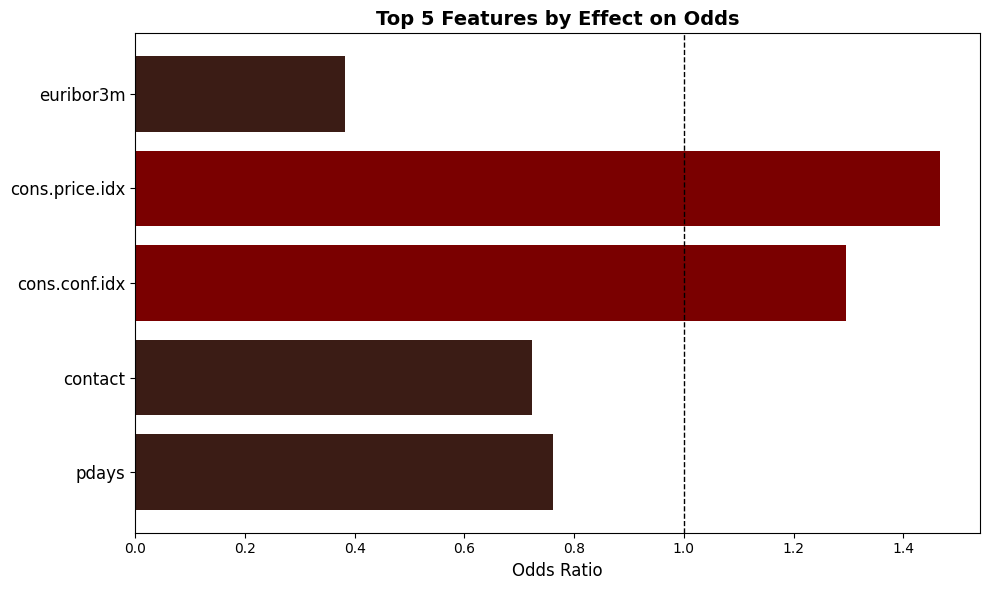

In [18]:
# Select top 5 (already sorted by Effect_Strength)
top_n = 5
top_coef = coef_sorted.head(top_n)

# Reverse for top = top visually
top_coef = top_coef.iloc[::-1]

# Color theme matching your PPT
color_positive = '#7A0000'  # dark red
color_negative = '#3B1C15'  # deep brown

colors = [
    color_positive if x > 1 else color_negative 
    for x in top_coef['Odds_Ratio']
]

plt.figure(figsize=(10, 6))
plt.barh(
    range(len(top_coef)),
    top_coef['Odds_Ratio'],
    color=colors
)

plt.yticks(range(len(top_coef)), top_coef['Feature'], fontsize=12)
plt.xlabel('Odds Ratio', fontsize=12)
plt.title(f'Top {top_n} Features by Effect on Odds', fontweight='bold', fontsize=14)

# Vertical line at OR = 1 (no effect)
plt.axvline(x=1, color='black', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()



THRESHOLD OPTIMIZATION - LOGISTIC REGRESSION

Threshold Analysis:
 Threshold  Precision   Recall  F1-Score  Accuracy  Calls_Made  Conversions_Found
      0.10   0.112731 1.000000  0.202620  0.113162        8232                928
      0.15   0.113065 0.997845  0.203115  0.117776        8190                926
      0.20   0.116553 0.971983  0.208146  0.166707        7739                902
      0.25   0.131599 0.921336  0.230303  0.306095        6497                855
      0.30   0.162001 0.848060  0.272036  0.488587        4858                787
      0.35   0.202228 0.782328  0.321381  0.627732        3590                726
      0.40   0.247382 0.738147  0.370571  0.717460        2769                685
      0.45   0.274160 0.712284  0.395927  0.755100        2411                661
      0.50   0.290308 0.681034  0.407085  0.776469        2177                632
      0.55   0.315595 0.645474  0.423921  0.802331        1898                599
      0.60   0.364173 0.598060 

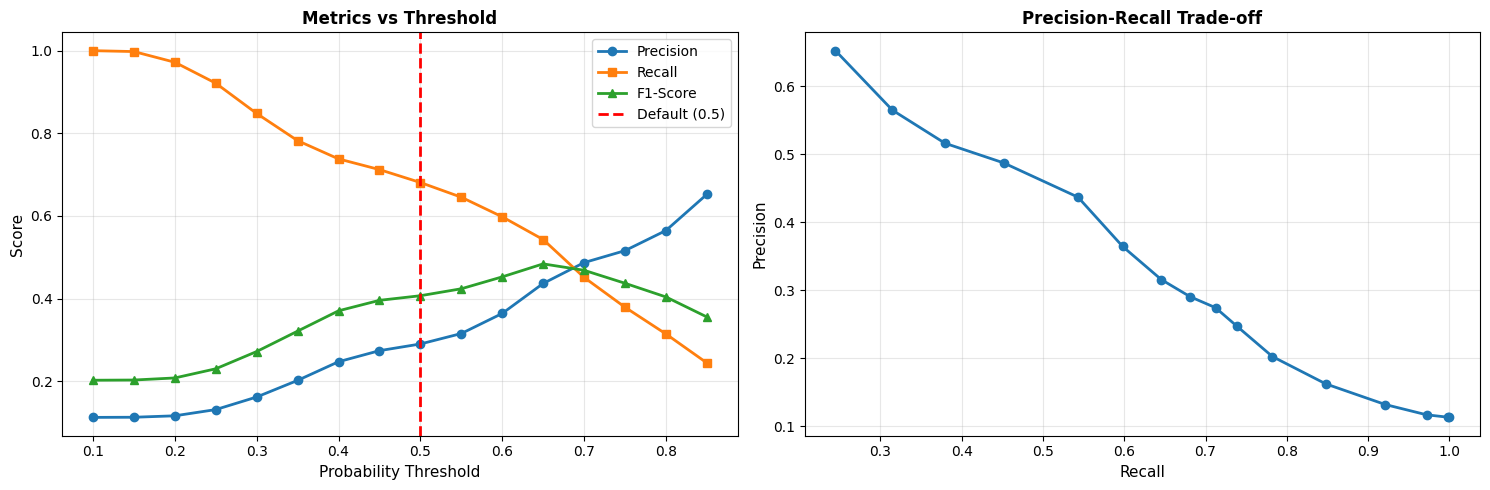


BUSINESS RECOMMENDATIONS

Current Setup (Threshold = 0.50):
  - Precision: 29.03% → 29 out of 100 predicted conversions are correct
  - Recall: 68.10% → Find 68 out of 100 actual conversions
  - Problem: Missing 32% of sales

RECOMMENDATION 1: Lower Threshold to 0.35
  - Find MORE conversions (higher recall)
  - Call more people (accept more false positives)
  - Best if: Budget allows extra calls, conversion value is high

RECOMMENDATION 2: Lower Threshold to 0.30
  - Find MOST conversions (maximize recall)
  - Call even more people (highest false positive rate)
  - Best if: Unlimited marketing budget, need to maximize sales volume

RECOMMENDATION 3: Raise Threshold to 0.65
  - Only call high-confidence prospects (higher precision)
  - Miss some sales but more efficient
  - Best if: Budget is tight, want efficiency over volume


COMPARING THRESHOLDS: 0.50 vs 0.35 vs 0.30

Threshold: 0.5
Accuracy: 0.7765
Precision: 0.2903
Recall: 0.6810
F1-Score: 0.4071

Business Metrics:
  Total predi

In [19]:
# Cell 10a: Threshold Optimization for Logistic Regression
from sklearn.metrics import precision_recall_curve

# Get precision-recall curve
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_test_pred_proba)

# Find optimal thresholds for different business goals
print("\n" + "="*80)
print("THRESHOLD OPTIMIZATION - LOGISTIC REGRESSION")
print("="*80)

# Create a dataframe of thresholds and their metrics
threshold_metrics = []

for threshold in np.arange(0.1, 0.9, 0.05):
    y_pred_threshold = (y_test_pred_proba >= threshold).astype(int)
    
    precision = precision_score(y_test, y_pred_threshold, zero_division=0)
    recall = recall_score(y_test, y_pred_threshold, zero_division=0)
    f1 = f1_score(y_test, y_pred_threshold, zero_division=0)
    accuracy = (y_pred_threshold == y_test).mean()
    
    threshold_metrics.append({
        'Threshold': threshold,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Accuracy': accuracy,
        'Calls_Made': y_pred_threshold.sum(),
        'Conversions_Found': (y_pred_threshold * y_test).sum()
    })

threshold_df = pd.DataFrame(threshold_metrics)
print("\nThreshold Analysis:")
print(threshold_df.to_string(index=False))

# Cell 10b: Visualize Precision-Recall Trade-off
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Threshold vs Metrics
axes[0].plot(threshold_df['Threshold'], threshold_df['Precision'], marker='o', label='Precision', linewidth=2)
axes[0].plot(threshold_df['Threshold'], threshold_df['Recall'], marker='s', label='Recall', linewidth=2)
axes[0].plot(threshold_df['Threshold'], threshold_df['F1-Score'], marker='^', label='F1-Score', linewidth=2)
axes[0].axvline(x=0.5, color='red', linestyle='--', label='Default (0.5)', linewidth=2)
axes[0].set_xlabel('Probability Threshold', fontsize=11)
axes[0].set_ylabel('Score', fontsize=11)
axes[0].set_title('Metrics vs Threshold', fontweight='bold', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Precision vs Recall (classic PR curve)
axes[1].plot(threshold_df['Recall'], threshold_df['Precision'], marker='o', linewidth=2, markersize=6)
for idx, row in threshold_df.iterrows():
    if row['Threshold'] in [0.3, 0.4, 0.5, 0.6]:
        axes[1].annotate(f"{row['Threshold']:.1f}", 
                        xy=(row['Recall'], row['Precision']),
                        xytext=(5, 5), textcoords='offset points', fontsize=9)
axes[1].set_xlabel('Recall', fontsize=11)
axes[1].set_ylabel('Precision', fontsize=11)
axes[1].set_title('Precision-Recall Trade-off', fontweight='bold', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Cell 10c: Business Recommendation
print("\n" + "="*80)
print("BUSINESS RECOMMENDATIONS")
print("="*80)

print("""
Current Setup (Threshold = 0.50):
  - Precision: 29.03% → 29 out of 100 predicted conversions are correct
  - Recall: 68.10% → Find 68 out of 100 actual conversions
  - Problem: Missing 32% of sales

RECOMMENDATION 1: Lower Threshold to 0.35
  - Find MORE conversions (higher recall)
  - Call more people (accept more false positives)
  - Best if: Budget allows extra calls, conversion value is high
  
RECOMMENDATION 2: Lower Threshold to 0.30
  - Find MOST conversions (maximize recall)
  - Call even more people (highest false positive rate)
  - Best if: Unlimited marketing budget, need to maximize sales volume

RECOMMENDATION 3: Raise Threshold to 0.65
  - Only call high-confidence prospects (higher precision)
  - Miss some sales but more efficient
  - Best if: Budget is tight, want efficiency over volume
""")

# Cell 10d: Apply Custom Threshold
print("\n" + "="*80)
print("COMPARING THRESHOLDS: 0.50 vs 0.35 vs 0.30")
print("="*80)

for threshold_val in [0.50, 0.35, 0.30]:
    y_pred_custom = (y_test_pred_proba >= threshold_val).astype(int)
    
    print(f"\n{'='*80}")
    print(f"Threshold: {threshold_val}")
    print(f"{'='*80}")
    print(f"Accuracy: {(y_pred_custom == y_test).mean():.4f}")
    print(f"Precision: {precision_score(y_test, y_pred_custom, zero_division=0):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred_custom, zero_division=0):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred_custom, zero_division=0):.4f}")
    
    print(f"\nBusiness Metrics:")
    print(f"  Total predictions: {len(y_pred_custom)}")
    print(f"  Calls predicted as 'YES': {y_pred_custom.sum():,}")
    print(f"  Conversions found: {(y_pred_custom * y_test).sum()}")
    print(f"  False positives (wasted calls): {((y_pred_custom == 1) & (y_test == 0)).sum():,}")
    print(f"  False negatives (missed sales): {((y_pred_custom == 0) & (y_test == 1)).sum()}")

# Cell 10e: Make Predictions with Custom Threshold (Example: 0.35)
OPTIMAL_THRESHOLD = 0.35

y_train_pred_custom = (y_train_pred_proba >= OPTIMAL_THRESHOLD).astype(int)
y_test_pred_custom = (y_test_pred_proba >= OPTIMAL_THRESHOLD).astype(int)

print("\n" + "="*80)
print(f"FINAL CHOICE: Using Threshold = {OPTIMAL_THRESHOLD}")
print("="*80)
print("\nTest Set Performance:")
print(f"Accuracy: {(y_test_pred_custom == y_test).mean():.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred_custom):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred_custom):.4f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred_custom):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_test_pred_proba):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_custom, target_names=['No Conversion', 'Conversion']))


OPTIMAL THRESHOLD BASED ON ROI - WITH PRECISION, RECALL & COST

Assumptions:
  • Conversion value: $200
  • Call cost: $5

 Threshold  Precision   Recall  Calls  Conversions  Cost  Revenue  Net_Profit
      0.10   0.112731 1.000000   8232          928 41160   185600      144440
      0.15   0.113065 0.997845   8190          926 40950   185200      144250
      0.20   0.116553 0.971983   7739          902 38695   180400      141705
      0.25   0.131599 0.921336   6497          855 32485   171000      138515
      0.30   0.162001 0.848060   4858          787 24290   157400      133110
      0.35   0.202228 0.782328   3590          726 17950   145200      127250
      0.40   0.247382 0.738147   2769          685 13845   137000      123155
      0.45   0.274160 0.712284   2411          661 12055   132200      120145
      0.50   0.290308 0.681034   2177          632 10885   126400      115515

RECOMMENDED THRESHOLD (Profit-max): 0.10
Precision: 0.1127
Recall: 1.0000
Net Profit: $144,440


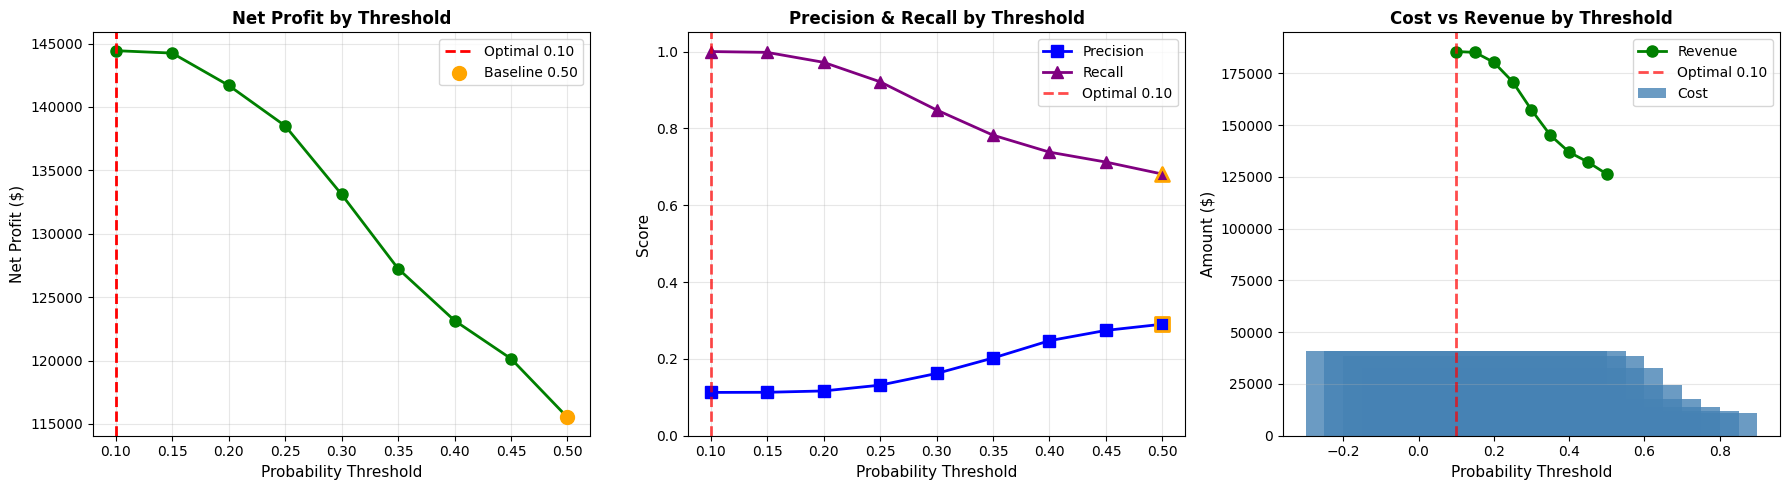

In [20]:
# Cell 11: Find Optimal Threshold Based on ROI (Combined with Precision/Recall/Cost Analysis)
print("\n" + "="*100)
print("OPTIMAL THRESHOLD BASED ON ROI - WITH PRECISION, RECALL & COST")
print("="*100)

# Business variables
CONVERSION_VALUE = 200  # $ per successful conversion (LTV)
CALL_COST = 5           # $ per call (with overhead)

print(f"\nAssumptions:")
print(f"  • Conversion value: ${CONVERSION_VALUE}")
print(f"  • Call cost: ${CALL_COST}")

# Calculate metrics for each threshold (0.10 to 0.50 step 0.05)
best_profit = -float('inf')
best_threshold = 0.5
roi_results = []

thresholds = np.arange(0.10, 0.51, 0.05)

for threshold in thresholds:
    y_pred = (y_test_pred_proba >= threshold).astype(int)
    
    conversions = int(((y_pred == 1) & (y_test == 1)).sum())  # True positives
    calls = int((y_pred == 1).sum())  # Total calls made
    
    revenue = conversions * CONVERSION_VALUE
    cost = calls * CALL_COST
    net_profit = revenue - cost
    
    # Calculate precision and recall
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    
    roi_results.append({
        'Threshold': threshold,
        'Precision': precision,
        'Recall': recall,
        'Calls': calls,
        'Conversions': conversions,
        'Cost': cost,
        'Revenue': revenue,
        'Net_Profit': net_profit
    })
    
    if net_profit > best_profit:
        best_profit = net_profit
        best_threshold = threshold

# Display full results table
results_df = pd.DataFrame(roi_results)
print("\n" + results_df.to_string(index=False))

# Highlight best threshold
print("\n" + "="*100)
print(f"RECOMMENDED THRESHOLD (Profit-max): {best_threshold:.2f}")
print("="*100)
best_row = results_df[results_df['Threshold'] == best_threshold].iloc[0]
print(f"Precision: {best_row['Precision']:.4f}")
print(f"Recall: {best_row['Recall']:.4f}")
print(f"Net Profit: ${best_row['Net_Profit']:,.0f}")
print(f"Conversions Found: {int(best_row['Conversions'])}")
print(f"Calls to Make: {int(best_row['Calls'])}")
print(f"Revenue: ${best_row['Revenue']:,.0f}")
print(f"Cost: ${best_row['Cost']:,.0f}")

# Baseline (standard 0.5 threshold) comparison
baseline_t = 0.5
baseline_preds = (y_test_pred_proba >= baseline_t).astype(int)
baseline_calls = int(baseline_preds.sum())
baseline_conversions = int(((baseline_preds == 1) & (y_test == 1)).sum())
baseline_revenue = baseline_conversions * CONVERSION_VALUE
baseline_cost = baseline_calls * CALL_COST
baseline_profit = baseline_revenue - baseline_cost
baseline_precision = precision_score(y_test, baseline_preds, zero_division=0)
baseline_recall = recall_score(y_test, baseline_preds, zero_division=0)

# Calculate delta
delta = best_row['Net_Profit'] - baseline_profit
pct = (delta / abs(baseline_profit)) * 100 if baseline_profit != 0 else float('nan')

print("\nComparison with Baseline (0.50):")
print(f"  Baseline threshold {baseline_t:.2f} -> Net profit: ${baseline_profit:,.0f} (Precision: {baseline_precision:.4f}, Recall: {baseline_recall:.4f})")
print(f"  Optimal threshold {best_threshold:.2f} -> Net profit: ${best_row['Net_Profit']:,.0f} (Precision: {best_row['Precision']:.4f}, Recall: {best_row['Recall']:.4f})")
print()
if delta >= 0:
    print(f"  MONEY SAVED / ADDED PROFIT by using optimal threshold: ${delta:,.0f} ({pct:.1f}% vs baseline)")
else:
    print(f"  MONEY LOST by using optimal threshold: ${-delta:,.0f} ({pct:.1f}% vs baseline)")

# Create comprehensive 3-panel visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Panel 1: Net Profit by Threshold
axes[0].plot(results_df['Threshold'], results_df['Net_Profit'], marker='o', lw=2, markersize=8, color='green')
axes[0].axvline(best_threshold, color='red', linestyle='--', linewidth=2, label=f'Optimal {best_threshold:.2f}')
axes[0].scatter([baseline_t], [baseline_profit], color='orange', zorder=5, s=100, label=f'Baseline {baseline_t:.2f}')
axes[0].set_xlabel('Probability Threshold', fontsize=11)
axes[0].set_ylabel('Net Profit ($)', fontsize=11)
axes[0].set_title('Net Profit by Threshold', fontweight='bold', fontsize=12)
axes[0].grid(alpha=0.3)
axes[0].legend(fontsize=10)

# Panel 2: Precision & Recall by Threshold
axes[1].plot(results_df['Threshold'], results_df['Precision'], marker='s', lw=2, markersize=8, label='Precision', color='blue')
axes[1].plot(results_df['Threshold'], results_df['Recall'], marker='^', lw=2, markersize=8, label='Recall', color='purple')
axes[1].axvline(best_threshold, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Optimal {best_threshold:.2f}')
axes[1].scatter([baseline_t], [baseline_precision], color='blue', marker='s', zorder=5, s=100, edgecolor='orange', linewidth=2)
axes[1].scatter([baseline_t], [baseline_recall], color='purple', marker='^', zorder=5, s=100, edgecolor='orange', linewidth=2)
axes[1].set_xlabel('Probability Threshold', fontsize=11)
axes[1].set_ylabel('Score', fontsize=11)
axes[1].set_title('Precision & Recall by Threshold', fontweight='bold', fontsize=12)
axes[1].set_ylim([0, 1.05])
axes[1].grid(alpha=0.3)
axes[1].legend(fontsize=10)

# Panel 3: Cost by Threshold
axes[2].bar(results_df['Threshold'], results_df['Cost'], alpha=0.8, color='steelblue', label='Cost')
axes[2].plot(results_df['Threshold'], results_df['Revenue'], marker='o', lw=2, color='green', markersize=8, label='Revenue')
axes[2].axvline(best_threshold, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Optimal {best_threshold:.2f}')
axes[2].set_xlabel('Probability Threshold', fontsize=11)
axes[2].set_ylabel('Amount ($)', fontsize=11)
axes[2].set_title('Cost vs Revenue by Threshold', fontweight='bold', fontsize=12)
axes[2].grid(alpha=0.3, axis='y')
axes[2].legend(fontsize=10)

plt.tight_layout()
plt.show()
